In [1]:
! pip install opendatasets

In [2]:
#imports
import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import opendatasets as od
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

#setings
#username:povergrrr
#key:4ab9a2b112addb191cdbdf82bacaae50
dataset_kaggle = "https://www.kaggle.com/oracledevrel/"
dataset_folder = "formulaaihackathon2022"
dataset_uri = dataset_kaggle+dataset_folder
dataset_file = dataset_folder + "/weather.csv"
DATATYPE = "datetime64[ns]"
FORMAT = '%Y-%m.%d %H:%M:%S'
DECISION = ['M_AIR_TEMPERATURE','M_TRACK_TEMPERATURE','M_RAIN_PERCENTAGE']
TIMESTAMP = 'TIMESTAMP'
WINDOW_SIZE = 30
columns = [
            'TIMESTAMP',
            'M_SESSION_UID',
            'M_TRACK_ID',
            'M_TRACK_TEMPERATURE', #wywalone bo ma 98% korelacji z M_AIR_TEMP ~Rafał
            'M_FORECAST_ACCURACY', 
            'M_AIR_TEMPERATURE', 
            'M_NUM_WEATHER_FORECAST_SAMPLES', 
            'M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE',
            'M_WEATHER_FORECAST_SAMPLES_M_WEATHER',
            'M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE', #korelacja na 99% ~Rafał
            'M_TRACK_TEMPERATURE_CHANGE',
            'M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE', #korelacja na 99% ~Rafał
            'M_AIR_TEMPERATURE_CHANGE', 
            'M_RAIN_PERCENTAGE',
            'M_WEATHER',
            'M_TIME_OFFSET'
        ]

#reading data
od.download(dataset_uri)
df = pd.read_csv(dataset_folder+'/weather.csv')

#TODO
#jak usunąć ten czerwony błąd? co to za tajemnicza 21 kolumna?

Skipping, found downloaded files in ".\formulaaihackathon2022" (use force=True to force download)


C:\Users\48785\anaconda3\envs\tensorflow_env\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(array([2664421.,       0.,  763609.,       0.,  101486.,       0.,
              0.,       0.,       0.,   42812.]),
 array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. ]),
 <a list of 10 Patch objects>)

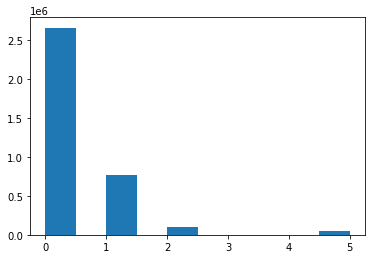

In [3]:
#histogram przed czyszczeniem danych
plt.hist(df['M_WEATHER'])

In [4]:
#preprocesing data
#z 3572328 do 532536 - usunięcie duplikatów
#z 532536 do 486142 - usunięcie dropna M_WEATHER_FORECAST_SAMPLES_M_WEATHER
#z 486142 do 475399 - usunięcie M_NUM_WEATHER_FORECAST_SAMPLES !=0
#z 475399 do 140615 - zostawienie tylko tych row, dla których M_TIME_OFFSET == 0

#cleaning data
print("Before cleaning:",str(len(df)))

df = df[columns]
df = df.dropna(subset=['M_WEATHER_FORECAST_SAMPLES_M_WEATHER'])
df = df[df['M_NUM_WEATHER_FORECAST_SAMPLES']!=0]
df = df[df['M_TIME_OFFSET']==0.0]       
df = df.drop(['M_TIME_OFFSET'], axis=1)
df = df.drop_duplicates()
    
print("After cleaning: ",str(len(df)))

#seting column type
if(df['TIMESTAMP'].dtypes != DATATYPE):
    df['TIMESTAMP'] = df['TIMESTAMP'].apply(datetime.datetime.fromtimestamp)
df['M_SESSION_UID'] = df['M_SESSION_UID'].apply(int)
    
df

Before cleaning: 3572328
After cleaning:  140615


,TIMESTAMP,M_SESSION_UID,M_TRACK_ID,M_TRACK_TEMPERATURE,M_FORECAST_ACCURACY,M_AIR_TEMPERATURE,M_NUM_WEATHER_FORECAST_SAMPLES,M_WEATHER_FORECAST_SAMPLES_M_SESSION_TYPE,M_WEATHER_FORECAST_SAMPLES_M_WEATHER,M_WEATHER_FORECAST_SAMPLES_M_TRACK_TEMPERATURE,M_TRACK_TEMPERATURE_CHANGE,M_WEATHER_FORECAST_SAMPLES_M_AIR_TEMPERATURE,M_AIR_TEMPERATURE_CHANGE,M_RAIN_PERCENTAGE,M_WEATHER
17038,2022-01-21 01:16:50,2939734289500381696,28,33,0,25,10,8.0,0.0,33.0,2.0,25.0,2.0,1.0,0
17041,2022-01-21 01:16:50,2939734289500381696,28,33,0,25,10,10.0,1.0,32.0,1.0,24.0,1.0,5.0,0
17048,2022-01-21 01:16:50,2939734289500381696,28,33,0,25,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
17115,2022-01-21 01:16:51,2939734289500381696,28,33,0,25,10,8.0,0.0,33.0,2.0,25.0,2.0,1.0,0
17118,2022-01-21 01:16:51,2939734289500381696,28,33,0,25,10,10.0,1.0,32.0,1.0,24.0,1.0,5.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3572208,2022-01-16 00:14:50,10862815468833218560,28,33,0,25,10,10.0,0.0,33.0,2.0,25.0,2.0,2.0,0
3572215,2022-01-16 00:14:50,10862815468833218560,28,33,0,25,10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3572282,2022-01-16 00:14:51,10862815468833218560,28,33,0,25,10,8.0,0.0,33.0,2.0,25.0,2.0,4.0,0
3572285,2022-01-16 00:14:51,10862815468833218560,28,33,0,25,10,10.0,0.0,33.0,2.0,25.0,2.0,2.0,0


(array([99887.,     0.,     0.,     0.,     0., 36905.,     0.,     0.,
            0.,  3823.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

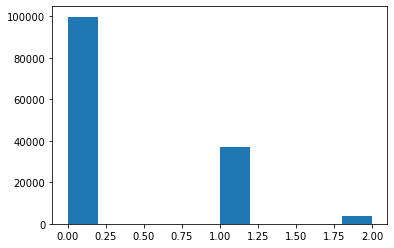

In [5]:
#hostogram po czyszczeniu danych + wnioski: Z naszej analizy wynika, że sesje, gdzie M_WEATHER===5 to gry customowe, w któych gracz ustawił const wartrtosc M_WEATHER i to sprawdza ta kolumna: M_NUM_WEATHER_FORECAST_SAMPLES
plt.hist(df['M_WEATHER'])

((140585, 30, 3), (140585, 3))

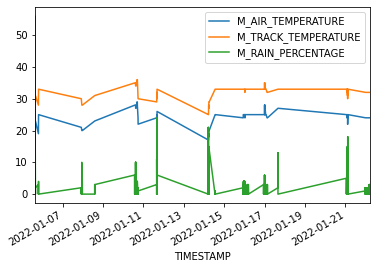

In [6]:
#LSTM - prepere data for models

df_1 = df.drop(['M_SESSION_UID'], axis=1)
df_2 = df.drop(['M_TRACK_ID'], axis=1)
df_3 = df.drop(['M_SESSION_UID', 'M_TRACK_ID'], axis=1)

df_1.index = pd.to_datetime(df_1[TIMESTAMP], format=FORMAT)
df_2.index = pd.to_datetime(df_2[TIMESTAMP], format=FORMAT)
df_3.index = pd.to_datetime(df_3[TIMESTAMP], format=FORMAT)

#fun 
def df_to_X_y(df, window_size=30):
  df_as_np =df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [r for r in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)



# Sesion ID (_1)




# Track ID (_2)


# ALL (_3)
temp = df_3[DECISION]
temp.plot()
X, y = df_to_X_y(temp, WINDOW_SIZE)
X.shape, y.shape
# number of rows = 140610 

#TODO model

In [7]:
X

array([[[25., 33.,  1.],
        [25., 33.,  5.],
        [25., 33.,  0.],
        ...,
        [25., 33.,  1.],
        [25., 33.,  5.],
        [25., 33.,  0.]],

       [[25., 33.,  5.],
        [25., 33.,  0.],
        [25., 33.,  1.],
        ...,
        [25., 33.,  5.],
        [25., 33.,  0.],
        [25., 33.,  1.]],

       [[25., 33.,  0.],
        [25., 33.,  1.],
        [25., 33.,  5.],
        ...,
        [25., 33.,  0.],
        [25., 33.,  1.],
        [25., 33.,  5.]],

       ...,

       [[25., 33.,  4.],
        [25., 33.,  2.],
        [25., 33.,  0.],
        ...,
        [25., 33.,  4.],
        [25., 33.,  2.],
        [25., 33.,  0.]],

       [[25., 33.,  2.],
        [25., 33.,  0.],
        [25., 33.,  4.],
        ...,
        [25., 33.,  2.],
        [25., 33.,  0.],
        [25., 33.,  4.]],

       [[25., 33.,  0.],
        [25., 33.,  4.],
        [25., 33.,  2.],
        ...,
        [25., 33.,  0.],
        [25., 33.,  4.],
        [25., 33.,  2.]]

In [8]:
#model variant 3 (ALL _3)

# split to train validation
X_train, y_train = X[:105458], y[:105458] #105458 rows
X_val, y_val = X[105458:123034], y[105458:123034] #17576 rows
X_test, y_test = X[123034:], y[123034:] #17576 rows

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

model1 = Sequential()
model1.add(InputLayer((12, 3)))
model1.add(LSTM(64))
model1.add(Dense(32, activation='tanh'))
model1.add(Dense(3))

model1.summary()

# we will monitor when to stop epochs, it depends on val_loss and it wont stop before 3 epochs no matter what
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=3)
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])
model1.summary()

(105458, 30, 3) (105458, 3)
(17576, 30, 3) (17576, 3)
(17551, 30, 3) (17551, 3)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17408     
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 99        
Total params: 19,587
Trainable params: 19,587
Non-trainable params: 0
_________________________________________________________________
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                17408     
_________________________________________________________________
dense (Dense)     

In [9]:
model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp1, early_stop])
model1 = load_model('model1/')

Epoch 1/10
3296/3296 [==============================] - 20s 6ms/step - loss: 285.0488 - root_mean_squared_error: 16.8834 - val_loss: 159.2742 - val_root_mean_squared_error: 12.6204


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 2/10
3296/3296 [==============================] - 19s 6ms/step - loss: 89.4370 - root_mean_squared_error: 9.4571 - val_loss: 47.3693 - val_root_mean_squared_error: 6.8825


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 3/10
3296/3296 [==============================] - 20s 6ms/step - loss: 20.8536 - root_mean_squared_error: 4.5666 - val_loss: 22.3628 - val_root_mean_squared_error: 4.7289


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 4/10
3296/3296 [==============================] - 19s 6ms/step - loss: 8.4169 - root_mean_squared_error: 2.9012 - val_loss: 8.6444 - val_root_mean_squared_error: 2.9401


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 5/10
3296/3296 [==============================] - 20s 6ms/step - loss: 4.1636 - root_mean_squared_error: 2.0405 - val_loss: 6.4875 - val_root_mean_squared_error: 2.5471


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 6/10
3296/3296 [==============================] - 20s 6ms/step - loss: 3.3735 - root_mean_squared_error: 1.8367 - val_loss: 4.1318 - val_root_mean_squared_error: 2.0327


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 7/10
3296/3296 [==============================] - 20s 6ms/step - loss: 2.1939 - root_mean_squared_error: 1.4812 - val_loss: 1.6552 - val_root_mean_squared_error: 1.2866


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 8/10
3296/3296 [==============================] - 20s 6ms/step - loss: 1.4048 - root_mean_squared_error: 1.1852 - val_loss: 0.8683 - val_root_mean_squared_error: 0.9318


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 9/10
3296/3296 [==============================] - 21s 6ms/step - loss: 1.0717 - root_mean_squared_error: 1.0352 - val_loss: 0.6939 - val_root_mean_squared_error: 0.8330


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


Epoch 10/10
3296/3296 [==============================] - 22s 7ms/step - loss: 0.9313 - root_mean_squared_error: 0.9651 - val_loss: 0.6228 - val_root_mean_squared_error: 0.7892


INFO:tensorflow:Assets written to: model1\assets


INFO:tensorflow:Assets written to: model1\assets


In [10]:
# we flatten becouse we dont want to have the X=[[[3], [4], [5], [6], [7]]] -> X=[[3, 4, 5, 6, 7]] inner brackets
train_predictions = model1.predict(X_train)
print(train_predictions.shape)
print(y_train.shape)

(105458, 3)
(105458, 3)


In [11]:
# we make a dataframe from results put in dict, and show it below
train_results = pd.DataFrame(data={'Train_air_temp':train_predictions[:,[0,]].flatten(),
                                   'Train_track_temp':train_predictions[:,[1,]].flatten(),
                                   'Train_rain_percentage':train_predictions[:,[2,]].flatten(),
                                   'Actuals_air_temp':y_train[:,[0,]].flatten(),
                                   'Actuals_track_temp':y_train[:,[1,]].flatten(),
                                   'Actuals_rain_percentage':y_train[:,[2,]].flatten()
                                  })
train_results

,Train_air_temp,Train_track_temp,Train_rain_percentage,Actuals_air_temp,Actuals_track_temp,Actuals_rain_percentage
0,24.805906,32.661724,2.404823,25.0,33.0,1.0
1,25.099287,32.738232,3.495519,25.0,33.0,5.0
2,25.040199,32.583809,-0.022486,25.0,33.0,0.0
3,24.805906,32.661724,2.404823,25.0,33.0,1.0
4,25.099287,32.738232,3.495519,25.0,33.0,5.0
...,...,...,...,...,...,...
105453,28.113497,35.080402,1.131231,28.0,35.0,1.0
105454,28.234198,35.202824,1.201681,28.0,35.0,2.0
105455,27.985836,34.956985,0.606188,28.0,35.0,0.0
105456,27.788643,35.199932,2.019768,28.0,35.0,2.0


In [12]:
# makind predictions on X_test data
test_predictions = model1.predict(X_test)

In [13]:
# we make a dataframe from results put in dict, and show it below
test_results = pd.DataFrame(data={'predicted_air_temp':test_predictions[:,[0,]].flatten(),
                                   'predicted_track_temp':test_predictions[:,[1,]].flatten(),
                                   'predicted_rain_percentage':test_predictions[:,[2,]].flatten(),
                                   'Actuals_air_temp':y_test[:,[0,]].flatten(),
                                   'Actuals_track_temp':y_test[:,[1,]].flatten(),
                                   'Actuals_rain_percentage':y_test[:,[2,]].flatten()
                                  })

test_results

,predicted_air_temp,predicted_track_temp,predicted_rain_percentage,Actuals_air_temp,Actuals_track_temp,Actuals_rain_percentage
0,27.985836,34.956985,0.606188,28.0,35.0,0.0
1,27.788643,35.199932,2.019768,28.0,35.0,2.0
2,27.977417,35.169182,6.057091,28.0,35.0,6.0
3,27.884140,34.860176,0.877592,28.0,35.0,1.0
4,28.010588,34.947502,0.631726,28.0,35.0,1.0
...,...,...,...,...,...,...
17546,24.809401,32.665504,2.234154,25.0,33.0,2.0
17547,25.075920,32.821068,0.606133,25.0,33.0,0.0
17548,25.207640,32.903877,3.809485,25.0,33.0,4.0
17549,24.809401,32.665504,2.234154,25.0,33.0,2.0


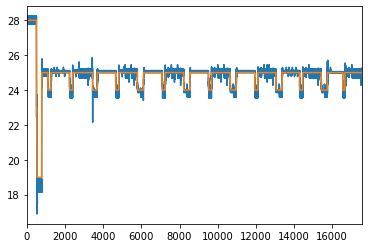

In [14]:
# Air temp
test_results['predicted_air_temp'].plot()
test_results['Actuals_air_temp'].plot()

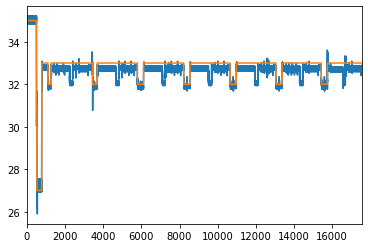

In [15]:
# Track temp
test_results['predicted_track_temp'].plot()
test_results['Actuals_track_temp'].plot()

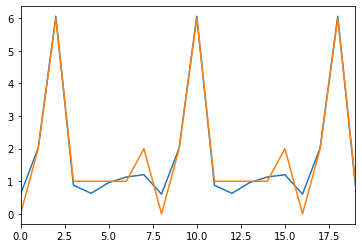

In [16]:
# Rain percentage
test_results['predicted_rain_percentage'][:20].plot()
test_results['Actuals_rain_percentage'][:20].plot()